# Prévisions météorologiques en Australie

# Prévision des précipitations avec étape de ré-échantillonage

## Récupération des librairies

In [1]:
# récupération du package scikit-plot
!pip install scikit-plot

In [2]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [3]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, datetime
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score, make_scorer, get_scorer_names, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

In [4]:
# définition d'une option de visualisation des DataFrames 
pd.set_option("display.max_colwidth", 200)

## Préparation du jeu de données et paramètrage

In [5]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [6]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [7]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)

In [8]:
# distribution de la variable cible dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible dans l'ensemble d'entraînement:", 
      dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble d'entraînement: {0: 76696, 1: 21854}


In [9]:
# distribution de la variable cible dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.778245
1    0.221755
Name: RainTomorrow, dtype: float64

In [10]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 32890, 1: 9347}


In [11]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.778701
1    0.221299
Name: RainTomorrow, dtype: float64

In [12]:
# paramètre à initialiser pour calculer les performances des algorithmes avec ré-échantillonage
# param_ru = 'rOs' # RandomOverSampler
param_ru = 'rUs' # RandomUnderSampler
# param_ru = 'smo' # SMOTE
# param_ru = 'cc' # ClusterCentroids

In [13]:
# oversampling des données
if param_ru == 'rOs':
    rOs = RandomOverSampler()
    X_train, y_train = rOs.fit_resample(X_train, y_train)
elif param_ru == 'smo':
    smo = SMOTE()
    X_train, y_train = smo.fit_resample(X_train, y_train)

In [14]:
# undersampling des données
if param_ru == 'rUs':
    rUs = RandomUnderSampler()
    X_train, y_train = rUs.fit_resample(X_train, y_train)
elif param_ru == 'cc':
    cc = ClusterCentroids()
    X_train, y_train = cc.fit_resample(X_train, y_train)

In [15]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 21854, 1: 21854}


In [16]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [17]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modèles de classification binaire par apprentissage supervisé

### Définition des fonctions et variables globales

In [18]:
# définition des métriques d'évaluation adaptées aux modèles de classification déséquilibrés 
scoring = {'f1':'f1_macro', 'accuracy':'balanced_accuracy', 'geom_mean':make_scorer(geometric_mean_score, greater_is_better=True), 'auc':'roc_auc'}

In [19]:
# affichage des performances moyennes obtenues par validation croisée pour les différentes métriques d'évaluation 
def error_metrics(model, data, target, kfold):
    error_metrics = pd.DataFrame(index=["cross-validation"], columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'])
    score = []
    result = cross_validate(model, data, target, cv=kfold, n_jobs=-1, scoring=scoring)
    for scor in scoring:
        score.append(result["test_"+scor].mean())
    score.append(result['fit_time'].mean())
    score.append(result['score_time'].mean())
    error_metrics.loc["cross-validation"] = score
    return error_metrics

In [20]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
def create_probas_dataframe(X_test_scaled, y_probas_test, y_test):
    df_probas_test = pd.DataFrame({'y_train_pred':y_probas_test[:,1], 'y_test':y_test})
    df_probas_test['Prévisions'] = df_probas_test.y_train_pred.map(lambda x: 1 if x > 0.5 else 0)
    for i in [float(x)/200 for x in range(200)]:
        df_probas_test[i] = df_probas_test.y_train_pred.map(lambda x: 1 if x > i else 0)
    return df_probas_test

In [21]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
def compute_metrics_with_probas(df_probas_test, y_test):
    df_metrics_probas = pd.DataFrame(columns = ['Probabilités','accuracy','sensitivité','spécificité','f1_score','f1_macro','bal_acc','moy_geom','roc_auc'])
    for i in [float(x)/200 for x in range(200)]:
        cm = metrics.confusion_matrix(y_test, df_probas_test[i])
        Accuracy = (cm[0,0]+cm[1,1])/np.sum(cm)
        Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
        Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
        F1_score = f1_score(y_test, df_probas_test[i])
        F1_macro = f1_score(y_test, df_probas_test[i], average='macro')
        Bal_Acc = balanced_accuracy_score(y_test, df_probas_test[i])
        Geom_Mean = geometric_mean_score(y_test, df_probas_test[i])
        ROC_AUC = roc_auc_score(y_test, df_probas_test[i])
        df_metrics_probas.loc[i] = [i, Accuracy, Sensitivity, Specificity, F1_score, F1_macro, Bal_Acc, Geom_Mean, ROC_AUC]
    return df_metrics_probas

In [22]:
def plot_metrics_with_probas(df_metrics_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    ax1 = df_metrics_probas.plot.line(x='Probabilités', y=['accuracy','sensitivité','spécificité'], fontsize='small', ax=ax1)
    for l in ax1.lines:
        l.set_lw(1.0)
    ax1.grid()
    ax1.legend(loc="lower center", fontsize="small")
    ax1.set_title("Recherche du seuil de probabilités optimal", fontsize="small")
    ax2 = df_metrics_probas.plot.line(x='Probabilités', y=['f1_score','f1_macro','bal_acc','moy_geom','roc_auc'], fontsize='small', ax=ax2)
    for l in ax2.lines:
        l.set_lw(1.0)
    ax2.grid()
    ax2.legend(loc="lower center", fontsize="small")
    ax2.set_title("Métriques principales et secondaires", fontsize="small");

In [23]:
# affichage des courbes ROC et de précision-rappel
def plot_roc_prec_rap(y_test, y_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1 = skplt.metrics.plot_roc(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small', ax=ax1)
    for l in ax1.lines:
        l.set_lw(1.0)
    ax1.grid()
    ax1.legend(loc="lower right", fontsize="small")
    ax1.set_title("Courbe ROC", fontsize="small")
    ax2 = skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(5,5), title_fontsize='small', text_fontsize='small', ax=ax2)
    for l in ax2.lines:
        l.set_lw(1.0)
    ax2.grid()
    ax2.legend(loc="lower right", fontsize="small")
    ax2.set_title("Courbe de précision-rappel", fontsize="small");

In [24]:
# affichage des courbes lift et de gain cumulé  
def plot_lift_gain(y_test, y_probas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1 = skplt.metrics.plot_lift_curve(y_test, y_probas, title_fontsize='small', text_fontsize='small', ax=ax1)
    for l in ax1.lines:
        l.set_lw(1.0)
    ax1.legend(loc="upper right", fontsize="small")
    ax1.set_title("Courbe lift", fontsize="small")
    ax2 = skplt.metrics.plot_cumulative_gain(y_test, y_probas, title_fontsize='small', text_fontsize='small', ax=ax2)
    for l in ax2.lines:
        l.set_lw(1.0)
    ax2.legend(loc="lower right", fontsize="small")
    ax2.set_title("Courbe de gain cumulé", fontsize="small");

### Régression Logistique

#### class_weight = None

In [25]:
# définition du modèle
clf_lr = LogisticRegression(class_weight=None)

In [26]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 'C':np.logspace(-3,3,7)}

In [27]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr0 = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr0.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [28]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'solver': 'liblinear'}",0.774572,0.774595,0.774529,0.856198,0.126259,0.020170
1,"{'C': 1.0, 'solver': 'sag'}",0.774572,0.774595,0.774529,0.856197,0.561883,0.021013
3,"{'C': 10.0, 'solver': 'lbfgs'}",0.774572,0.774595,0.774528,0.856197,0.061062,0.021180


In [29]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1.0, 'solver': 'liblinear'} 

Train Data Score: 0.7750304409341219
Test Data Score: 0.7249851798441018


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [30]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_lr0_train = error_metrics(gcv_lr0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_lr0_test = error_metrics(gcv_lr0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_lr0_train)
display("TEST", cv_lr0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.774572,0.774595,0.774529,0.856198,0.062813,0.011477


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.738599,0.713352,0.6752,0.854338,0.081864,0.01142


In [31]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_lr0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.273590,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.690678,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.765335,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.287549,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.224819,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_lr0 = compute_metrics_with_probas(df_probas_test, y_test)

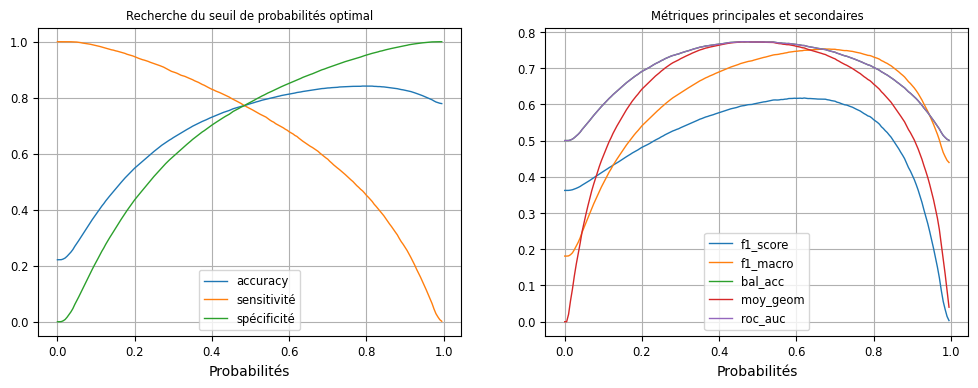

In [33]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_lr0)

In [34]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_lr0['Probabilités'].values
f = df_metrics_probas_lr0['sensitivité'].values
g = df_metrics_probas_lr0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_lr0, y_prob_thres_lr0) = thres_info[0]

In [35]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_lr0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_lr0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_lr0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.48

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25306  7584
1             2101  7246

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84     32890
           1       0.49      0.78      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.77      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.77      0.78      0.84      0.77      0.60     32890
          1       0.49      0.78      0.77      0.60      0.77      0.60      9347

avg / total       0.83      0.77      0.77      0.79      0.77      0.60     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

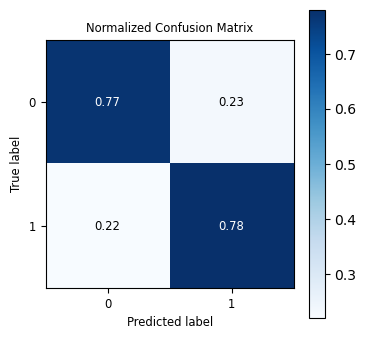

In [36]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

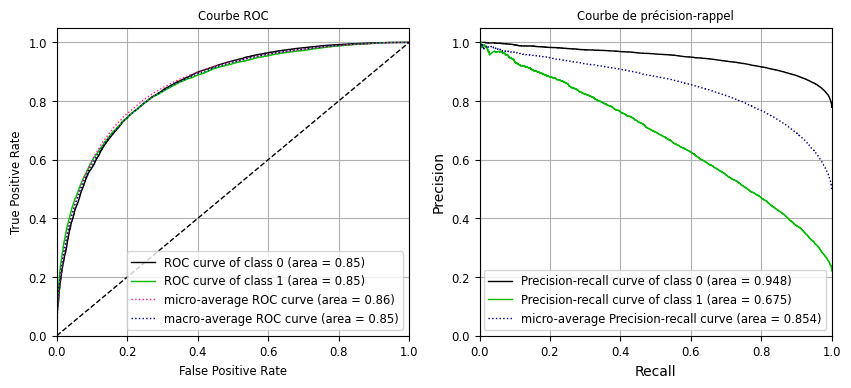

In [37]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

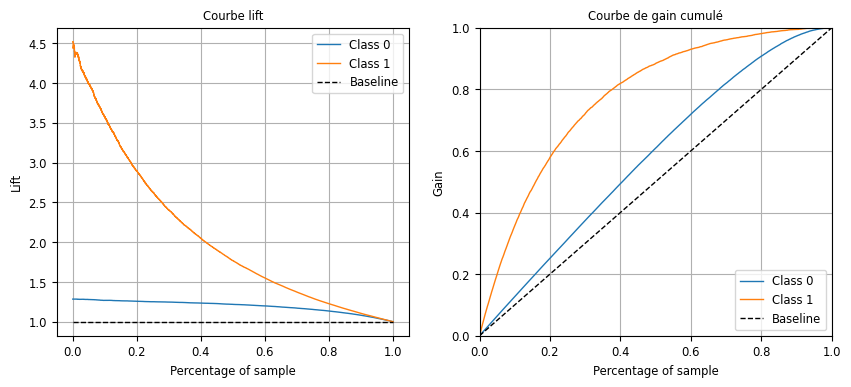

In [38]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = 'balanced'

In [39]:
# définition du modèle
clf_lr = LogisticRegression(class_weight='balanced')

In [40]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'], 'C':np.logspace(-3,3,7)}

In [41]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr1 = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [42]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'solver': 'sag'}",0.774572,0.774595,0.774529,0.856198,0.490246,0.018022
2,"{'C': 100.0, 'solver': 'sag'}",0.774549,0.774572,0.774506,0.856197,0.430784,0.015017
3,"{'C': 1.0, 'solver': 'newton-cg'}",0.774549,0.774572,0.774506,0.856197,0.211698,0.018130


In [43]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1.0, 'solver': 'sag'} 

Train Data Score: 0.7750304409341219
Test Data Score: 0.7249851798441018


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [44]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_lr1_train = error_metrics(gcv_lr1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_lr1_test = error_metrics(gcv_lr1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_lr1_train)
display("TEST", cv_lr1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.774549,0.774572,0.774506,0.856197,0.210129,0.010182


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.724218,0.771663,0.771554,0.854631,0.188956,0.011145


In [45]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_lr1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.273597,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.690704,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.765332,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.287580,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.224791,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_lr1 = compute_metrics_with_probas(df_probas_test, y_test)

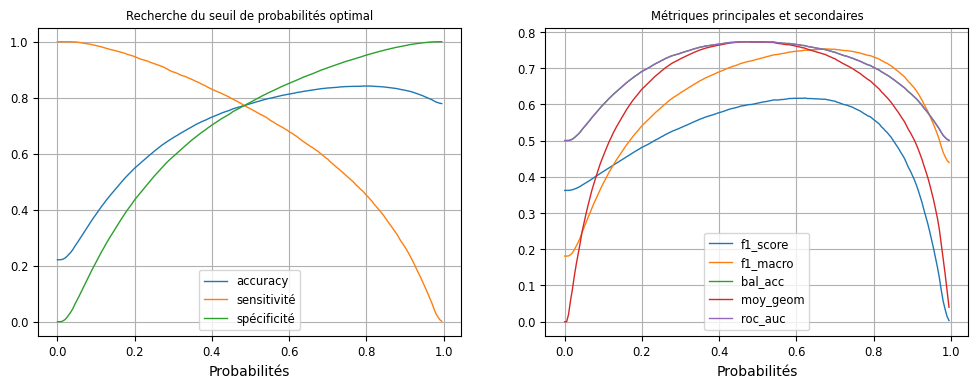

In [47]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_lr1)

In [48]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_lr1['Probabilités'].values
f = df_metrics_probas_lr1['sensitivité'].values
g = df_metrics_probas_lr1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_lr1, y_prob_thres_lr1) = thres_info[0]

In [49]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_lr1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_lr1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_lr1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.48

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25306  7584
1             2101  7246

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84     32890
           1       0.49      0.78      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.77      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.77      0.78      0.84      0.77      0.60     32890
          1       0.49      0.78      0.77      0.60      0.77      0.60      9347

avg / total       0.83      0.77      0.77      0.79      0.77      0.60     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

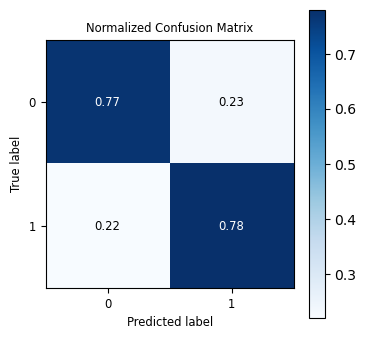

In [50]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

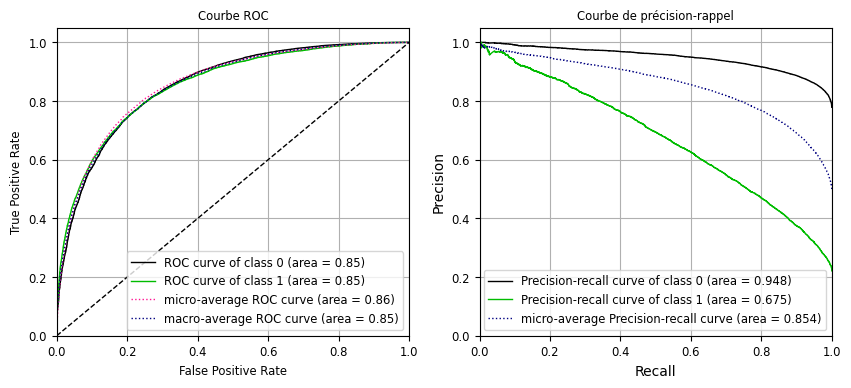

In [51]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

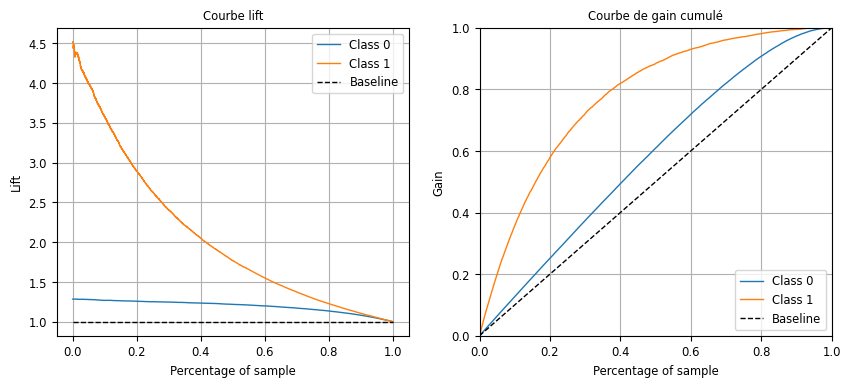

In [52]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [53]:
# définition du modèle
clf_lr = LogisticRegression()

In [54]:
# définition de l'intervalle pour le coefficient de pondération
weights = [float(x)/40 for x in range(40)]

In [55]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_lr = {'solver':[gcv_lr0.best_params_['solver']], 'C':[gcv_lr0.best_params_['C']], 'class_weight': [{0:x, 1:1.0-x} for x in weights]} 

In [56]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr2 = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring=scoring, refit="f1", n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_lr2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.025, 1: 0.975},
                                          {0: 0.05, 1: 0.95},
                                          {0: 0.075, 1: 0.925},
                                          {0: 0.1, 1: 0.9},
                                          {0: 0.125, 1: 0.875},
                                          {0: 0.15, 1: 0.85},
                                          {0: 0.175, 1: 0.825},
                                          {0: 0.2, 1: 0.8},
                                          {0: 0.225, 1: 0.775},
                                          {0: 0.25, 1: 0.75},
                                          {0: 0.275, 1: 0.725},
                                          {0: 0.3, 1: 0.7},
                                          {0: 0.325, 1: 0.675},
                                          {0: 0.35, 1: 0.65},
                                          {0: 0.37...
                                          {0: 0.55, 1: 0.44999999999999996},
                                          {0: 0.575, 1: 0.42500000000000004},
                                          {0: 0.6, 1: 0.4},
                                          {0: 0.625, 1: 0.375},
                                          {0: 0.65, 1: 0.35},
                                          {0: 0.675, 1: 0.32499999999999996},
                                          {0: 0.7, 1: 0.30000000000000004},
                                          {0: 0.725, 1: 0.275}, ...],
                         'solver': ['liblinear']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [57]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_lr2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'class_weight': {0: 0.5, 1: 0.5}, 'solver': 'liblinear'}",0.774549,0.774572,0.774506,0.856197,0.153585,0.018328
2,"{'C': 1.0, 'class_weight': {0: 0.475, 1: 0.525}, 'solver': 'liblinear'}",0.773611,0.773634,0.773568,0.856203,0.155695,0.019681
3,"{'C': 1.0, 'class_weight': {0: 0.525, 1: 0.475}, 'solver': 'liblinear'}",0.773123,0.773314,0.772770,0.856187,0.173749,0.019344


In [58]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1.0, 'class_weight': {0: 0.5, 1: 0.5}, 'solver': 'liblinear'} 

Train Data Score: 0.7750304409341219
Test Data Score: 0.7249485871736625


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [59]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_lr2_train = error_metrics(gcv_lr2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_lr2_test = error_metrics(gcv_lr2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_lr2_train)
display("TEST", cv_lr2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.774549,0.774572,0.774506,0.856197,0.05823,0.011481


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.738598,0.713375,0.675253,0.854337,0.070631,0.014553


In [60]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_lr2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.273647,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.690715,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.765236,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.287433,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.224876,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_lr2 = compute_metrics_with_probas(df_probas_test, y_test)

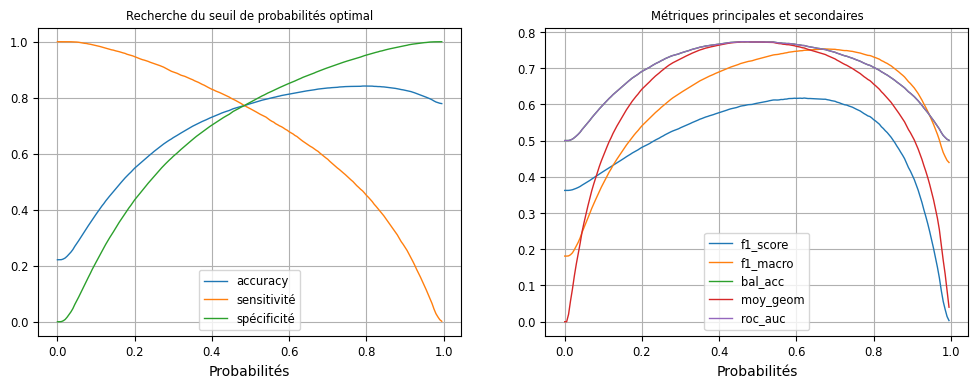

In [62]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_lr2)

In [63]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_lr2['Probabilités'].values
f = df_metrics_probas_lr2['sensitivité'].values
g = df_metrics_probas_lr2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_lr2, y_prob_thres_lr2) = thres_info[0]

In [64]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_lr2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_lr2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_lr2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.48

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25305  7585
1             2101  7246

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84     32890
           1       0.49      0.78      0.60      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.77      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.77      0.78      0.84      0.77      0.60     32890
          1       0.49      0.78      0.77      0.60      0.77      0.60      9347

avg / total       0.83      0.77      0.77      0.79      0.77      0.60     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

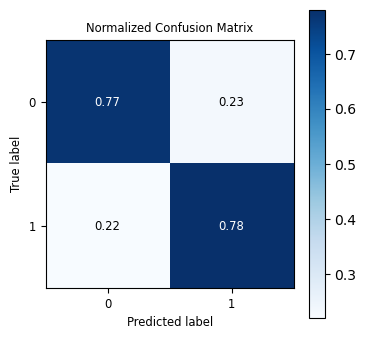

In [65]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

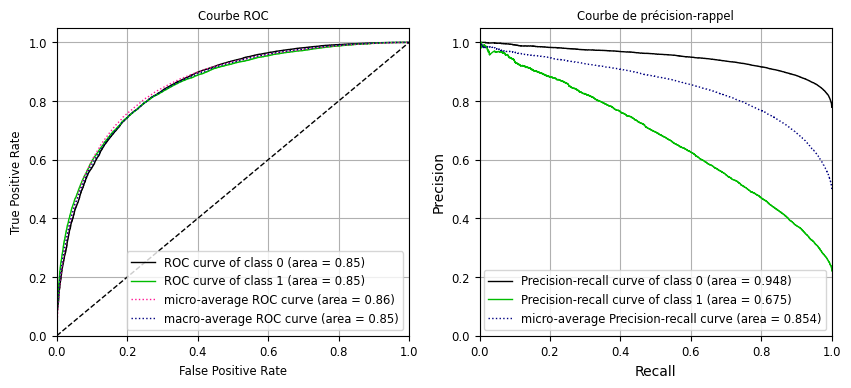

In [66]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

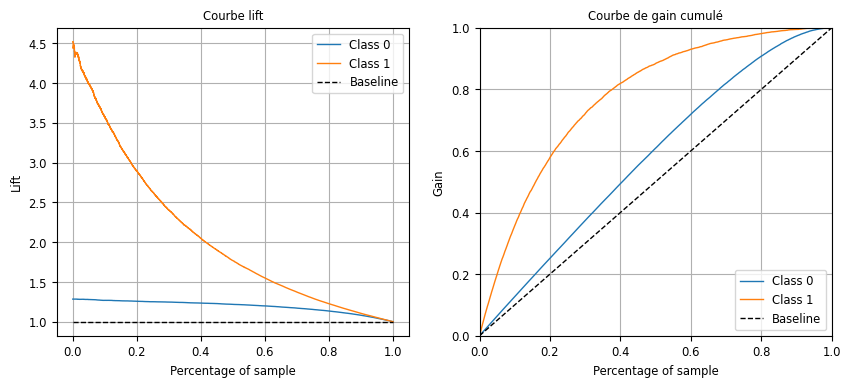

In [67]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [68]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_lr = pd.DataFrame(data=[cv_lr0_train.values[0], cv_lr0_test.values[0], cv_lr1_train.values[0], cv_lr1_test.values[0], 
                           cv_lr2_train.values[0], cv_lr2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'], 
                     index=['lr0 : train', 'lr0 : test', 'lr1 : train', 'lr1 : test', 'lr2 : train', 'lr2 : test'])
cv_lr.index.name='Cross validation'
cv_lr.to_csv('../scores/cv_lr_'+param_ru+'.csv')
cv_lr

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
lr0 : train,0.774572,0.774595,0.774529,0.856198,0.062813,0.011477
lr0 : test,0.738599,0.713352,0.675200,0.854338,0.081864,0.011420
lr1 : train,0.774549,0.774572,0.774506,0.856197,0.210129,0.010182
lr1 : test,0.724218,0.771663,0.771554,0.854631,0.188956,0.011145
lr2 : train,0.774549,0.774572,0.774506,0.856197,0.058230,0.011481
lr2 : test,0.738598,0.713375,0.675253,0.854337,0.070631,0.014553


In [69]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_lr = {'lr0' : df_metrics_probas_lr0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_lr0],
           'lr1' : df_metrics_probas_lr1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_lr1],
           'lr2' : df_metrics_probas_lr2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_lr2]}

test_lr = pd.DataFrame(data=[data_lr['lr0'], data_lr['lr1'], data_lr['lr2']], 
                       columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                       index=['lr1', 'lr2', 'lr3'])
test_lr.index.name='Final Test'
test_lr.to_csv('../scores/test_lr_'+param_ru+'.csv')
test_lr

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
lr1,0.599413,0.719396,0.772318,0.772312,0.772318
lr2,0.599413,0.719396,0.772318,0.772312,0.772318
lr3,0.599388,0.719374,0.772302,0.772297,0.772302


### Forêts Aléatoires

#### class_weight = None

In [70]:
# définition du modèle
clf_rf = RandomForestClassifier(class_weight=None)

In [71]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_rf = [{'n_estimators':np.arange(150,210,25), 'min_samples_leaf':np.arange(1,4,1), 'max_features':['sqrt', 'log2']}]

In [72]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf0 = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf0.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': array([1, 2, 3]),
                          'n_estimators': array([150, 175, 200])}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [73]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175}",0.788036,0.788048,0.788011,0.871008,7.839890,1.126582
2,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 200}",0.787921,0.787934,0.787896,0.871720,8.790654,1.271941
3,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 150}",0.787510,0.787522,0.787487,0.871546,6.407664,0.940611


In [74]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175} 

Train Data Score: 0.9780817954472587
Test Data Score: 0.7405977643030177


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [75]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_rf0_train = error_metrics(gcv_rf0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_rf0_test = error_metrics(gcv_rf0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_rf0_train)
display("TEST", cv_rf0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.786413,0.786424,0.786391,0.871553,5.058741,0.852935


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.748177,0.718118,0.677444,0.86621,4.955575,0.758133


In [76]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_rf0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.235716,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.656190,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.543728,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.233607,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.437930,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_rf0 = compute_metrics_with_probas(df_probas_test, y_test)

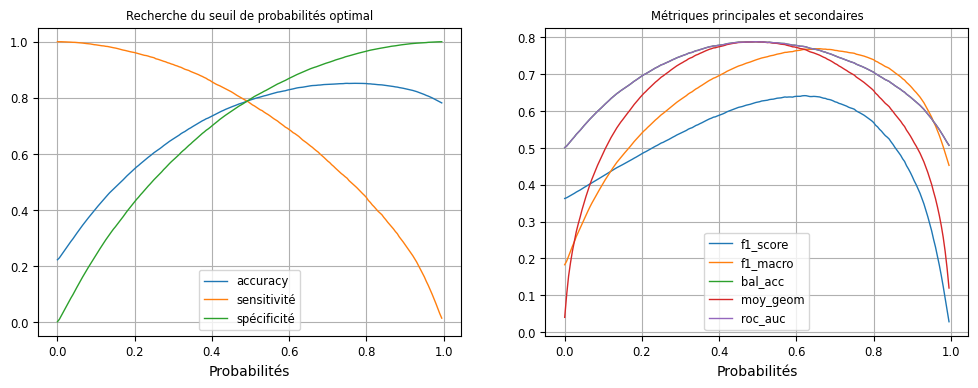

In [78]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_rf0)

In [79]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_rf0['Probabilités'].values
f = df_metrics_probas_rf0['sensitivité'].values
g = df_metrics_probas_rf0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_rf0, y_prob_thres_rf0) = thres_info[0]

In [80]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_rf0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_rf0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_rf0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.49

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25886  7004
1             1973  7374

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     32890
           1       0.51      0.79      0.62      9347

    accuracy                           0.79     42237
   macro avg       0.72      0.79      0.74     42237
weighted avg       0.84      0.79      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.79      0.85      0.79      0.62     32890
          1       0.51      0.79      0.79      0.62      0.79      0.62      9347

avg / total       0.84      0.79      0.79      0.80      0.79      0.62     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.62`

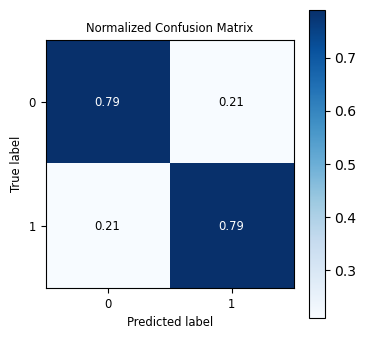

In [81]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

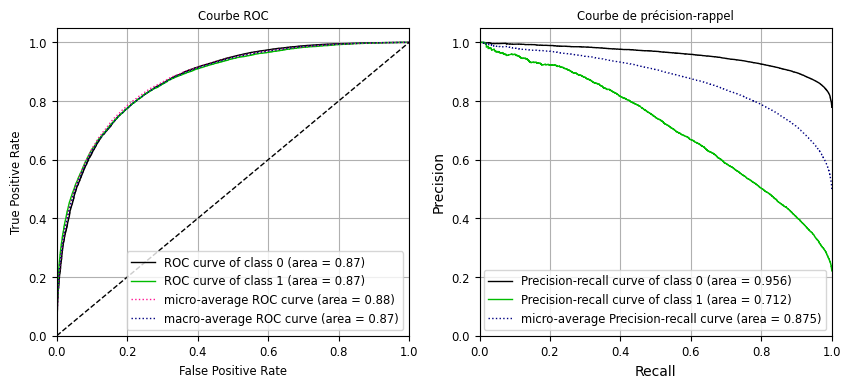

In [82]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

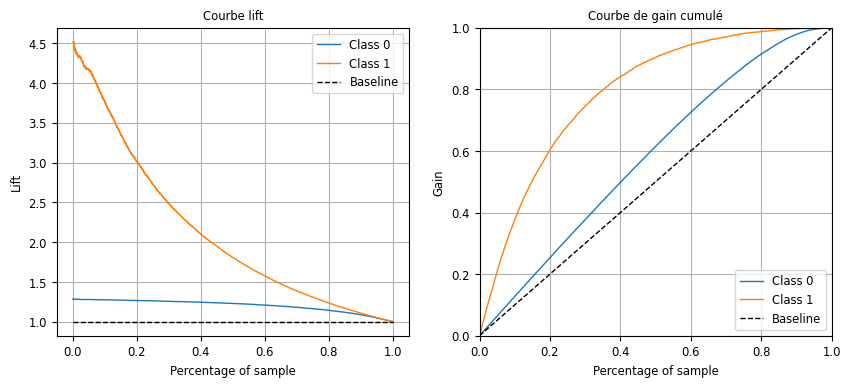

In [83]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = 'balanced'

In [84]:
# définition du modèle
clf_rf = RandomForestClassifier(class_weight='balanced')

In [85]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_rf = [{'n_estimators':np.arange(150,210,25), 'min_samples_leaf':np.arange(1,4,1), 'max_features':['sqrt', 'log2']}]

In [86]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf1 = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid=[{'max_features': ['sqrt', 'log2'],
                          'min_samples_leaf': array([1, 2, 3]),
                          'n_estimators': array([150, 175, 200])}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [87]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}",0.788099,0.788117,0.788064,0.870788,9.714231,1.369668
2,"{'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}",0.787964,0.787979,0.787933,0.871510,8.978348,1.324278
3,"{'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 150}",0.787812,0.787819,0.787796,0.871342,6.360982,0.948168


In [88]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200} 

Train Data Score: 1.0
Test Data Score: 0.7408095726224544


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [89]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_rf1_train = error_metrics(gcv_rf1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_rf1_test = error_metrics(gcv_rf1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_rf1_train)
display("TEST", cv_rf1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.785947,0.785966,0.78591,0.870511,6.244574,0.998476


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.740371,0.708645,0.662255,0.865961,5.777117,0.926524


In [90]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_rf1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.325,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.655,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.575,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.210,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.520,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_rf1 = compute_metrics_with_probas(df_probas_test, y_test)

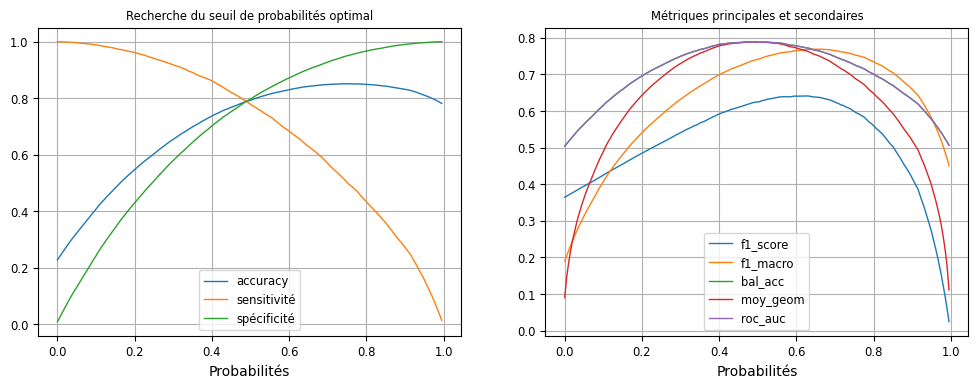

In [92]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_rf1)

In [93]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_rf1['Probabilités'].values
f = df_metrics_probas_rf1['sensitivité'].values
g = df_metrics_probas_rf1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_rf1, y_prob_thres_rf1) = thres_info[0]

In [94]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_rf1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_rf1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_rf1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.485

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25673  7217
1             1906  7441

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     32890
           1       0.51      0.80      0.62      9347

    accuracy                           0.78     42237
   macro avg       0.72      0.79      0.73     42237
weighted avg       0.84      0.78      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.78      0.80      0.85      0.79      0.62     32890
          1       0.51      0.80      0.78      0.62      0.79      0.62      9347

avg / total       0.84      0.78      0.79      0.80      0.79      0.62     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.78-0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.62`

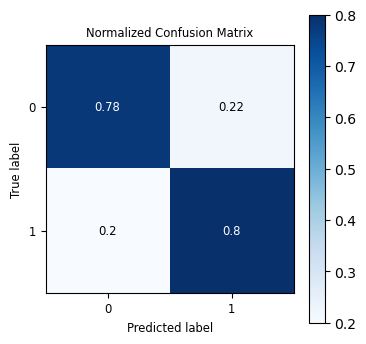

In [95]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

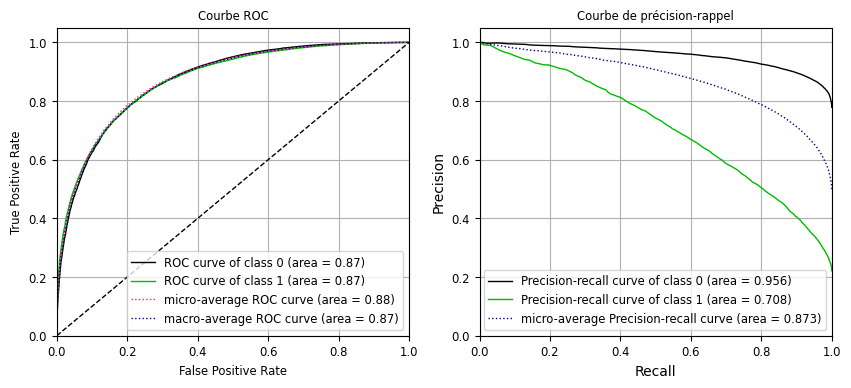

In [96]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

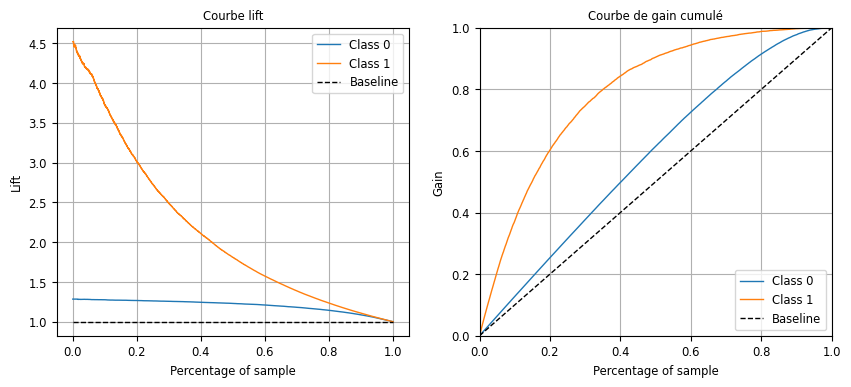

In [97]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [98]:
# définition du modèle
clf_rf = RandomForestClassifier()

In [99]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.45,0.55,11)

In [100]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_rf = [{'n_estimators':[gcv_rf0.best_params_['n_estimators']], 'min_samples_leaf':[gcv_rf0.best_params_['min_samples_leaf']], 
                  'max_features':[gcv_rf0.best_params_['max_features']], 'class_weight':[{0:x, 1:1.0-x} for x in weights]}]

In [101]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_rf2 = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring=scoring, refit="f1", n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_rf2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'class_weight': [{0: 0.45, 1: 0.55},
                                           {0: 0.46, 1: 0.54},
                                           {0: 0.47000000000000003, 1: 0.53},
                                           {0: 0.48000000000000004, 1: 0.52},
                                           {0: 0.49000000000000005, 1: 0.51},
                                           {0: 0.5, 1: 0.5}, {0: 0.51, 1: 0.49},
                                           {0: 0.52, 1: 0.48},
                                           {0: 0.53, 1: 0.47},
                                           {0: 0.54, 1: 0.45999999999999996},
                                           {0: 0.55, 1: 0.44999999999999996}],
                          'max_features': ['sqrt'], 'min_samples_leaf': [2],
                          'n_estimators': [175]}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [102]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_rf2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'class_weight': {0: 0.45, 1: 0.55}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175}",0.787864,0.787865,0.787863,0.871324,7.793623,1.201339
2,"{'class_weight': {0: 0.48000000000000004, 1: 0.52}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175}",0.787817,0.787819,0.787813,0.871556,8.410746,1.232957
3,"{'class_weight': {0: 0.46, 1: 0.54}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175}",0.787613,0.787613,0.787611,0.871410,8.076380,1.215838


In [103]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_rf2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'class_weight': {0: 0.45, 1: 0.55}, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 175} 

Train Data Score: 0.9781726293921417
Test Data Score: 0.7364746005021927


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [104]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_rf2_train = error_metrics(gcv_rf2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_rf2_test = error_metrics(gcv_rf2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_rf2_train)
display("TEST", cv_rf2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.78775,0.78775,0.787748,0.871385,5.186524,0.86758


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.752454,0.723519,0.685833,0.866946,4.96281,0.770578


In [105]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_rf2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.366039,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.657468,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.654156,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.256011,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.391467,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_rf2 = compute_metrics_with_probas(df_probas_test, y_test)

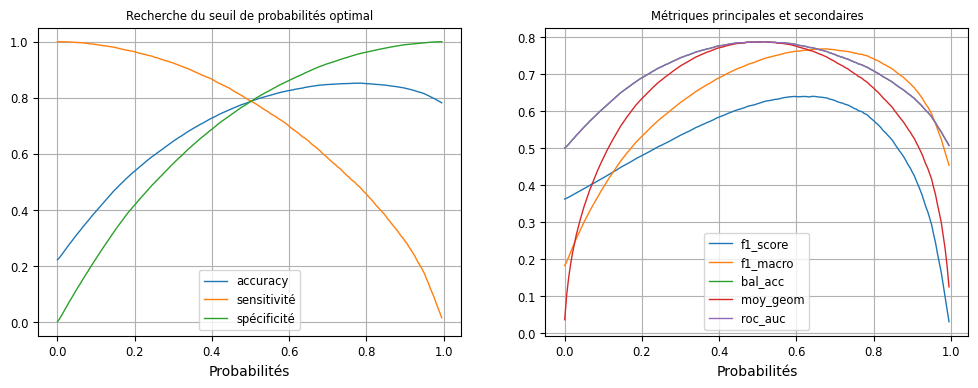

In [107]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_rf2)

In [108]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_rf2['Probabilités'].values
f = df_metrics_probas_rf2['sensitivité'].values
g = df_metrics_probas_rf2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_rf2, y_prob_thres_rf2) = thres_info[0]

In [109]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_rf2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_rf2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_rf2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.5

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25866  7024
1             1973  7374

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     32890
           1       0.51      0.79      0.62      9347

    accuracy                           0.79     42237
   macro avg       0.72      0.79      0.74     42237
weighted avg       0.84      0.79      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.79      0.79      0.85      0.79      0.62     32890
          1       0.51      0.79      0.79      0.62      0.79      0.62      9347

avg / total       0.84      0.79      0.79      0.80      0.79      0.62     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.78-0.79`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.62`

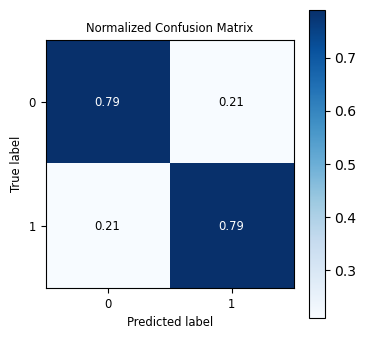

In [110]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

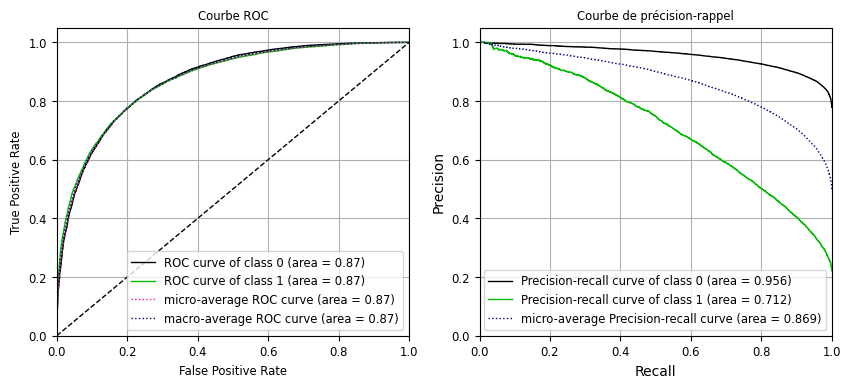

In [111]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

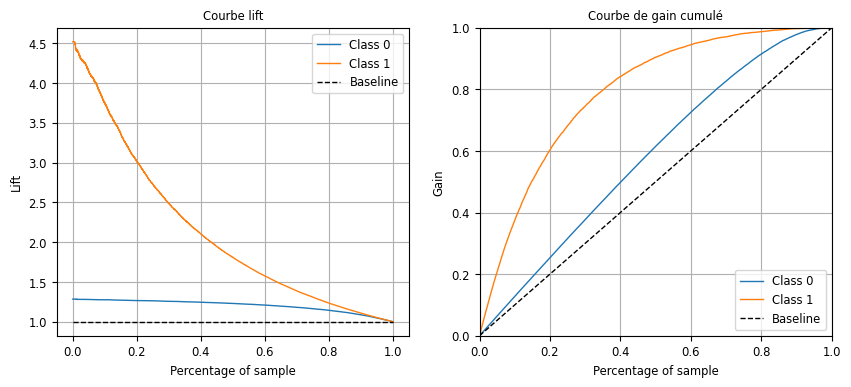

In [112]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [113]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_rf = pd.DataFrame(data=[cv_rf0_train.values[0], cv_rf0_test.values[0], cv_rf1_train.values[0], cv_rf1_test.values[0], 
                           cv_rf2_train.values[0], cv_rf2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'],
                     index=['rf0 : train', 'rf0 : test', 'rf1 : train', 'rf1 : test', 'rf2 : train', 'rf2 : test'])
cv_rf.index.name='Cross validation'
cv_rf.to_csv('../scores/cv_rf_'+param_ru+'.csv')
cv_rf

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
rf0 : train,0.786413,0.786424,0.786391,0.871553,5.058741,0.852935
rf0 : test,0.748177,0.718118,0.677444,0.866210,4.955575,0.758133
rf1 : train,0.785947,0.785966,0.785910,0.870511,6.244574,0.998476
rf1 : test,0.740371,0.708645,0.662255,0.865961,5.777117,0.926524
rf2 : train,0.787750,0.787750,0.787748,0.871385,5.186524,0.867580
rf2 : test,0.752454,0.723519,0.685833,0.866946,4.962810,0.770578


In [114]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_rf = {'rf0' : df_metrics_probas_rf0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_rf0],
           'rf1' : df_metrics_probas_rf1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_rf1],
           'rf2' : df_metrics_probas_rf2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_rf2]}

test_rf = pd.DataFrame(data=[data_rf['rf0'], data_rf['rf1'], data_rf['rf2']], 
                       columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                       index=['rf0', 'rf1', 'rf2'])
test_rf.index.name='Final Test'
test_rf.to_csv('../scores/test_rf_'+param_ru+'.csv')
test_rf

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
rf0,0.621623,0.736925,0.787982,0.787981,0.787982
rf1,0.622077,0.736842,0.788919,0.788911,0.788919
rf2,0.621099,0.736475,0.787678,0.787677,0.787678


### Séparateurs à Vaste Marge

#### class_weight = None

In [115]:
# définition du modèle
clf_svm = SVC(probability=True, class_weight=None)

In [116]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_svm = {'kernel':['rbf'], 'gamma':np.logspace(0,1,2), 'C':np.logspace(0,1,2)}

In [117]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm0 = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=2, return_train_score=True)

# entraînement du modèle
gcv_svm0.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([ 1., 10.]), 'gamma': array([ 1., 10.]),
                         'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [118]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                           'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.775634,0.775647,0.775609,0.838002,580.677272,98.223882
2,"{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.736897,0.736913,0.736871,0.797981,789.897400,69.405114
3,"{'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}",0.639776,0.655395,0.621450,0.754233,582.601886,132.774267


In [119]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'} 

Train Data Score: 0.8931745179472992
Test Data Score: 0.7292486186001355


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [120]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_svm0_train = error_metrics(gcv_svm0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_svm0_test = error_metrics(gcv_svm0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_svm0_train)
display("TEST", cv_svm0_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.782161,0.782168,0.782147,0.843558,527.921674,57.166783


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.714056,0.683927,0.625921,0.816777,464.11913,46.452916


In [121]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_svm0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.220134,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.681945,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.730602,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.309672,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.228818,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_svm0 = compute_metrics_with_probas(df_probas_test, y_test)

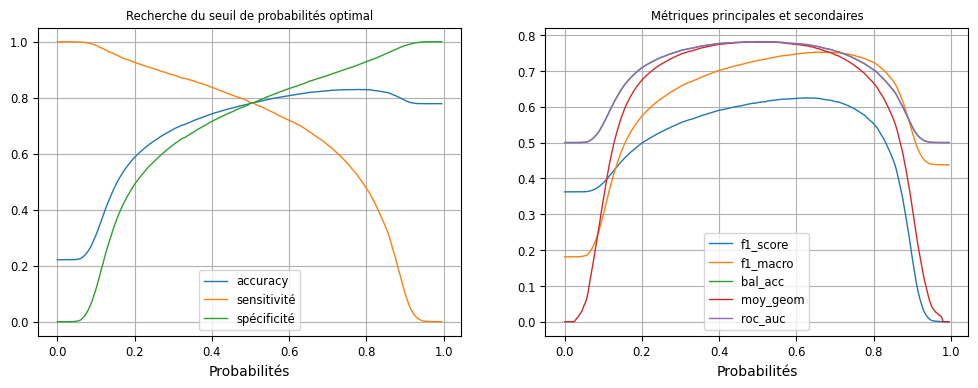

In [123]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_svm0)

In [124]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_svm0['Probabilités'].values
f = df_metrics_probas_svm0['sensitivité'].values
g = df_metrics_probas_svm0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_svm0, y_prob_thres_svm0) = thres_info[0]

In [125]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_svm0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_svm0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_svm0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.505

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25674  7216
1             2043  7304

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     32890
           1       0.50      0.78      0.61      9347

    accuracy                           0.78     42237
   macro avg       0.71      0.78      0.73     42237
weighted avg       0.83      0.78      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.78      0.78      0.85      0.78      0.61     32890
          1       0.50      0.78      0.78      0.61      0.78      0.61      9347

avg / total       0.83      0.78      0.78      0.80      0.78      0.61     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

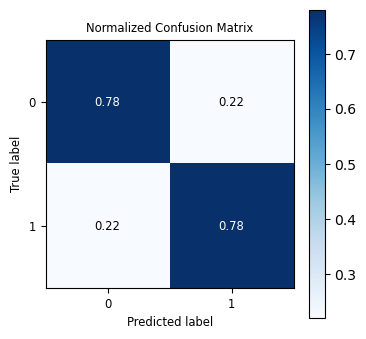

In [126]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

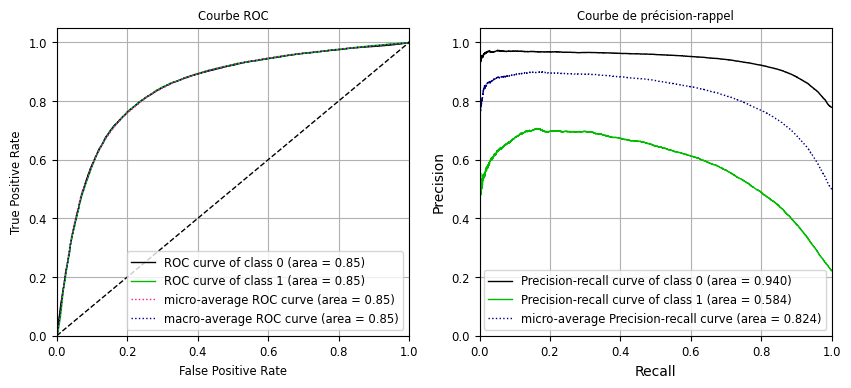

In [127]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

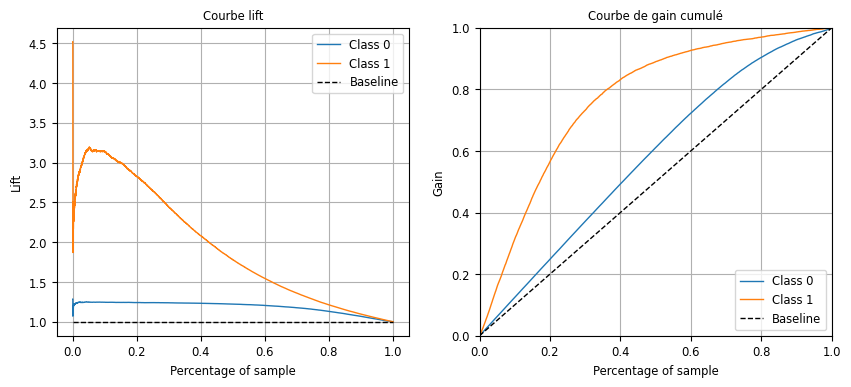

In [128]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = 'balanced'

In [129]:
# définition du modèle
clf_svm = SVC(probability=True, class_weight='balanced')

In [130]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_svm = {'kernel':[gcv_svm0.best_params_['kernel']], 'gamma':[gcv_svm0.best_params_['gamma']], 'C':[gcv_svm0.best_params_['C']]} 

In [131]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm1 = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=2, return_train_score=True)

# entraînement du modèle
gcv_svm1.fit(X_train_scaled, y_train)

GridSearchCV(cv=2, estimator=SVC(class_weight='balanced', probability=True),
             n_jobs=-1,
             param_grid={'C': [1.0], 'gamma': [1.0], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [132]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                           'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}",0.775634,0.775647,0.775609,0.838002,254.251901,64.175231


In [133]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'} 

Train Data Score: 0.8931745179472992
Test Data Score: 0.7292486186001355


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [134]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_svm1_train = error_metrics(gcv_svm1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_svm1_test = error_metrics(gcv_svm1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_svm1_train)
display("TEST", cv_svm1_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.782161,0.782168,0.782147,0.843557,551.319716,55.26173


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.736512,0.747214,0.738446,0.829353,445.326957,49.226003


In [135]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_svm1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.221358,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.683219,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.731730,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.311134,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.230070,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [136]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_svm1 = compute_metrics_with_probas(df_probas_test, y_test)

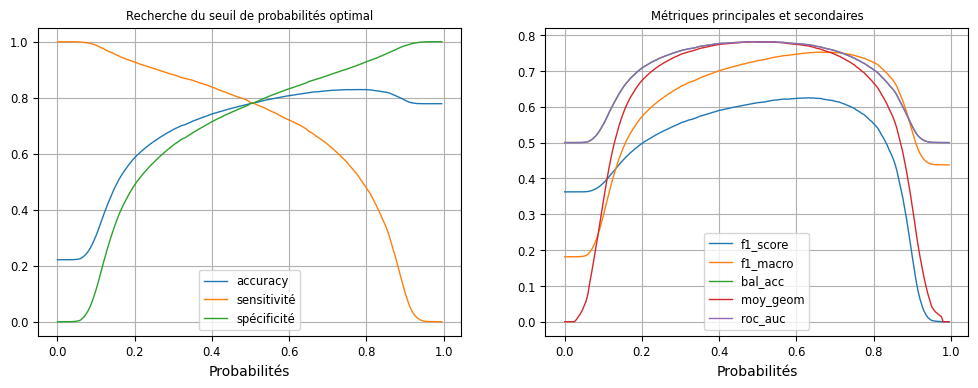

In [137]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_svm1)

In [138]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_svm1['Probabilités'].values
f = df_metrics_probas_svm1['sensitivité'].values
g = df_metrics_probas_svm1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_svm1, y_prob_thres_svm1) = thres_info[0]

In [139]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_svm1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_svm1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_svm1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.505

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25644  7246
1             2036  7311

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     32890
           1       0.50      0.78      0.61      9347

    accuracy                           0.78     42237
   macro avg       0.71      0.78      0.73     42237
weighted avg       0.83      0.78      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.78      0.78      0.85      0.78      0.61     32890
          1       0.50      0.78      0.78      0.61      0.78      0.61      9347

avg / total       0.83      0.78      0.78      0.79      0.78      0.61     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

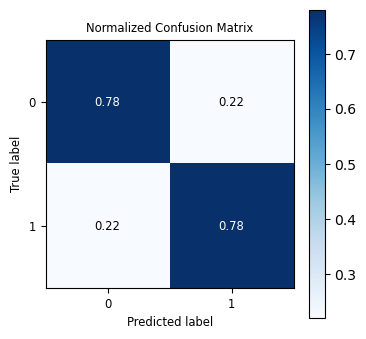

In [140]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

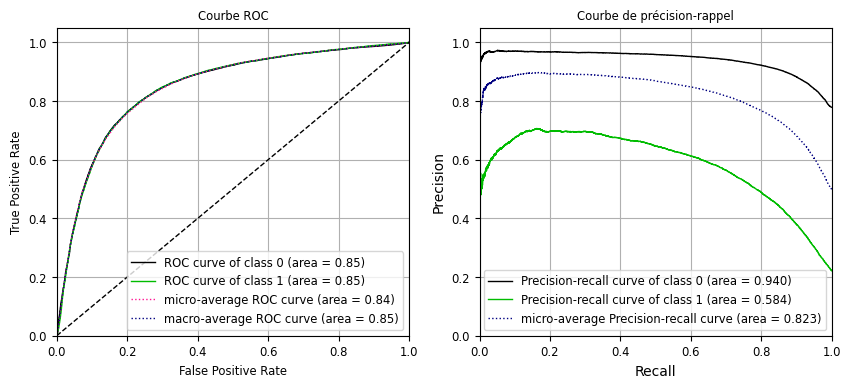

In [141]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

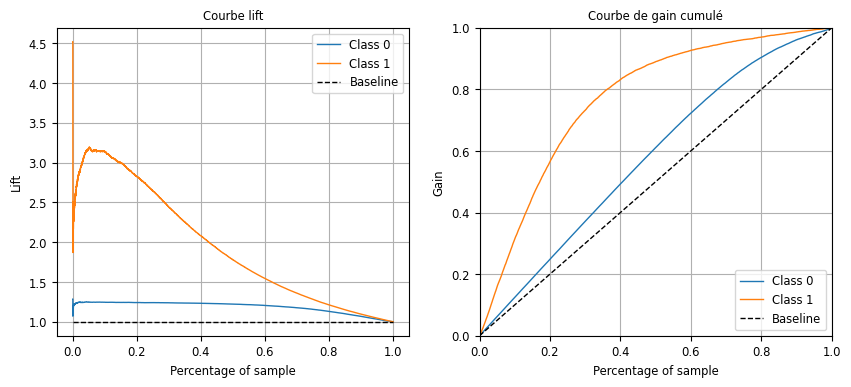

In [142]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [143]:
# définition du modèle
clf_svm = SVC(probability=True)

In [144]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.5,0.55,6)

In [145]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_svm = {'kernel':[gcv_svm0.best_params_['kernel']], 'gamma':[gcv_svm0.best_params_['gamma']], 
                  'C':[gcv_svm0.best_params_['C']], 'class_weight': [{0:x, 1:1.0-x} for x in weights]} 

In [146]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_svm2 = GridSearchCV(clf_svm, param_grid=param_grid_svm, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_svm2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1.0],
                         'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.51, 1: 0.49},
                                          {0: 0.52, 1: 0.48},
                                          {0: 0.53, 1: 0.47},
                                          {0: 0.54, 1: 0.45999999999999996},
                                          {0: 0.55, 1: 0.44999999999999996}],
                         'gamma': [1.0], 'kernel': ['rbf']},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [147]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_svm2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                           'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'C': 1.0, 'class_weight': {0: 0.52, 1: 0.48}, 'gamma': 1.0, 'kernel': 'rbf'}",0.783986,0.783998,0.783960,0.847252,946.179146,116.466826
2,"{'C': 1.0, 'class_weight': {0: 0.51, 1: 0.49}, 'gamma': 1.0, 'kernel': 'rbf'}",0.783897,0.783907,0.783880,0.847239,955.009362,117.639198
3,"{'C': 1.0, 'class_weight': {0: 0.53, 1: 0.47}, 'gamma': 1.0, 'kernel': 'rbf'}",0.783757,0.783838,0.783599,0.847210,946.627193,119.845520


In [148]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_svm2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_svm2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_svm2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'C': 1.0, 'class_weight': {0: 0.52, 1: 0.48}, 'gamma': 1.0, 'kernel': 'rbf'} 

Train Data Score: 0.8612029213801282
Test Data Score: 0.7387196783129013


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [149]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_svm2_train = error_metrics(gcv_svm2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_svm2_test = error_metrics(gcv_svm2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_svm2_train)
display("TEST", cv_svm2_test)

'TRAIN'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.783986,0.783998,0.78396,0.847252,414.758204,57.648599


'TEST'

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
cross-validation,0.670476,0.641856,0.547102,0.816998,415.293953,46.137955


In [150]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_svm2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.221915,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.674395,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.698026,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.270857,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.182742,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [151]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_svm2 = compute_metrics_with_probas(df_probas_test, y_test)

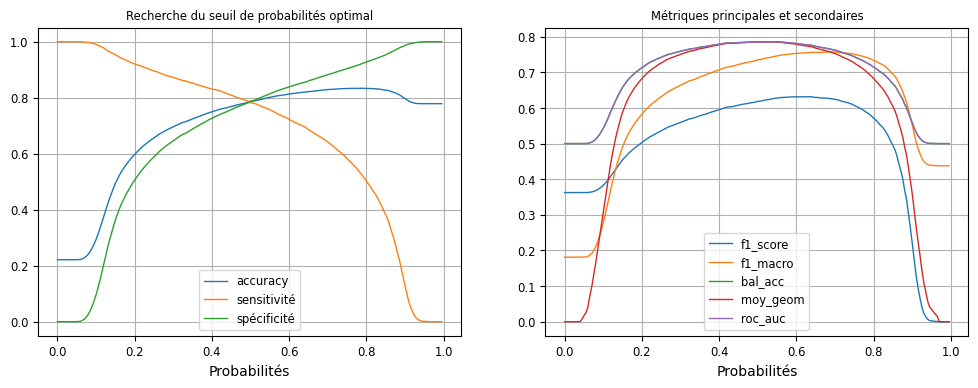

In [152]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_svm2)

In [153]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_svm2['Probabilités'].values
f = df_metrics_probas_svm2['sensitivité'].values
g = df_metrics_probas_svm2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_svm2, y_prob_thres_svm2) = thres_info[0]

In [154]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_svm2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_svm2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_svm2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.495

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            25743  7147
1             1993  7354

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.78      0.85     32890
           1       0.51      0.79      0.62      9347

    accuracy                           0.78     42237
   macro avg       0.72      0.78      0.73     42237
weighted avg       0.83      0.78      0.80     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.78      0.79      0.85      0.78      0.62     32890
          1       0.51      0.79      0.78      0.62      0.78      0.62      9347

avg / total       0.83      0.78      0.79      0.80      0.78      0.62     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

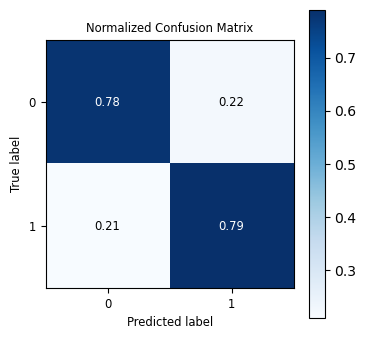

In [155]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

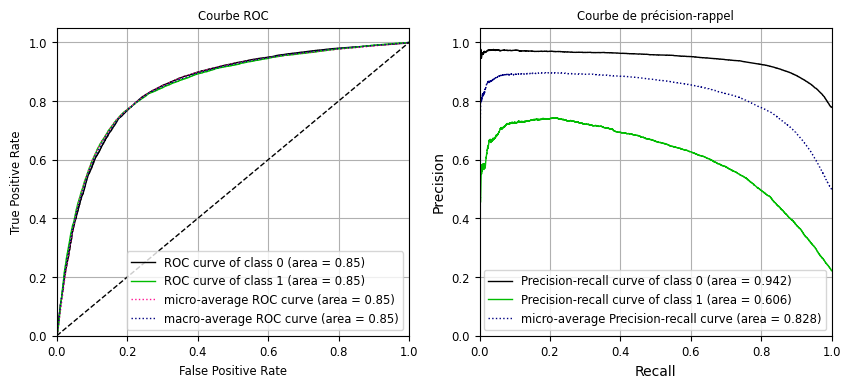

In [156]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

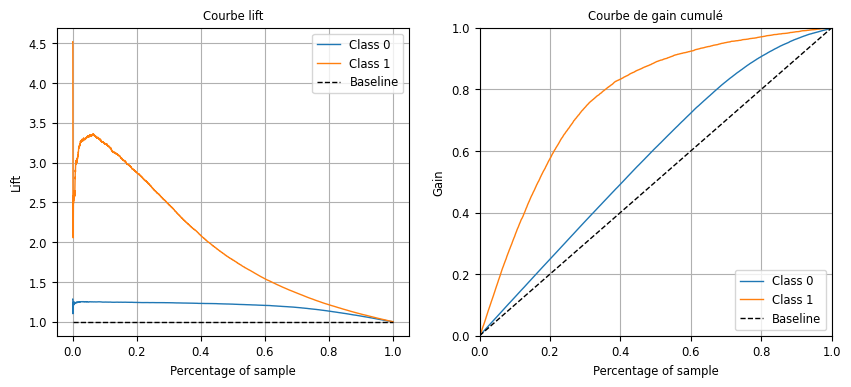

In [157]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [158]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_svm = pd.DataFrame(data=[cv_svm0_train.values[0], cv_svm0_test.values[0], cv_svm1_train.values[0], cv_svm1_test.values[0], 
                            cv_svm2_train.values[0], cv_svm2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'],
                     index=['svm0 : train', 'svm0 : test', 'svm1 : train', 'svm1 : test', 'svm2 : train', 'svm2 : test'])
cv_svm.index.name='Cross validation'
cv_svm.to_csv('../scores/cv_svm_'+param_ru+'.csv')
cv_svm

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
svm0 : train,0.782161,0.782168,0.782147,0.843558,527.921674,57.166783
svm0 : test,0.714056,0.683927,0.625921,0.816777,464.119130,46.452916
svm1 : train,0.782161,0.782168,0.782147,0.843557,551.319716,55.261730
svm1 : test,0.736512,0.747214,0.738446,0.829353,445.326957,49.226003
svm2 : train,0.783986,0.783998,0.783960,0.847252,414.758204,57.648599
svm2 : test,0.670476,0.641856,0.547102,0.816998,415.293953,46.137955


In [159]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_svm = {'svm0' : df_metrics_probas_svm0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_svm0],
            'svm1' : df_metrics_probas_svm1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_svm1],
            'svm2' : df_metrics_probas_svm2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_svm2]}

test_svm = pd.DataFrame(data=[data_svm['svm0'], data_svm['svm1'], data_svm['svm2']], 
                        columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                        index=['svm0', 'svm1', 'svm2'])
test_svm.index.name='Final Test'
test_svm.to_csv('../scores/test_svm_'+param_ru+'.csv')
test_svm

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
svm0,0.612058,0.729644,0.781015,0.781014,0.781015
svm1,0.611697,0.729226,0.780933,0.780932,0.780933
svm2,0.616739,0.732989,0.784738,0.784736,0.784738


### K-plus proches voisins

In [174]:
# définition du modèle
clf_knn = neighbors.KNeighborsClassifier()

In [175]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_knn = {'n_neighbors':np.arange(20,30,1), 'metric':['minkowski','manhattan'], 'p':[1, 2]}

In [176]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_knn = GridSearchCV(clf_knn, param_grid=param_grid_knn, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'manhattan'],
                         'n_neighbors': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': [1, 2]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [177]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_knn.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'metric': 'manhattan', 'n_neighbors': 25, 'p': 2}",0.78054,0.780567,0.780489,0.862762,0.119250,48.689971
1,"{'metric': 'minkowski', 'n_neighbors': 25, 'p': 1}",0.78054,0.780567,0.780489,0.862762,0.125433,46.913750
1,"{'metric': 'manhattan', 'n_neighbors': 25, 'p': 1}",0.78054,0.780567,0.780489,0.862762,0.117497,47.263953


In [178]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_knn.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_knn.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_knn.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'metric': 'minkowski', 'n_neighbors': 25, 'p': 1} 

Train Data Score: 0.7977070485646294
Test Data Score: 0.7341589076824039


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [179]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_knn_train = error_metrics(gcv_knn.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_knn_test = error_metrics(gcv_knn.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_knn_train)
display("TEST", cv_knn_test)

'TRAIN'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.78054,0.780567,0.780489,0.862762,0.054869,10.799405


'TEST'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.737564,0.707742,0.662852,0.855756,0.052967,9.579575


In [180]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_knn.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.40,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.64,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.48,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.12,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.20,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [181]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_knn = compute_metrics_with_probas(df_probas_test, y_test)

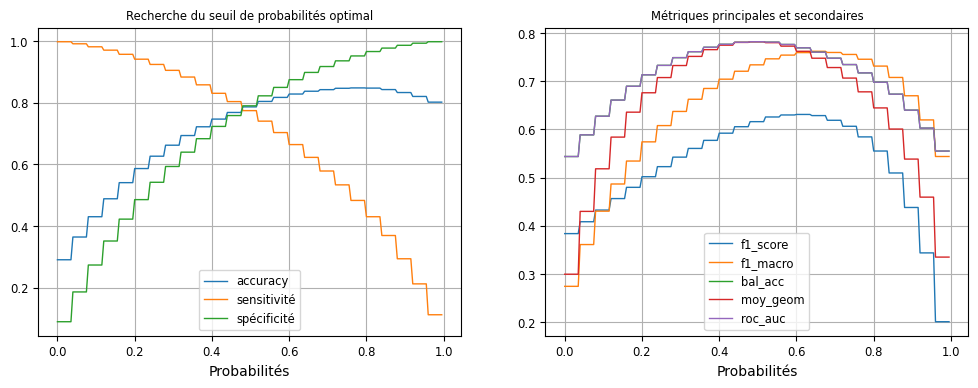

In [182]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_knn)

In [183]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_knn['Probabilités'].values
f = df_metrics_probas_knn['sensitivité'].values
g = df_metrics_probas_knn['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_knn, y_prob_thres_knn) = thres_info[0]

In [184]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_knn.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_knn).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_knn)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.475

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24944  7946
1             1835  7512

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.76      0.84     32890
           1       0.49      0.80      0.61      9347

    accuracy                           0.77     42237
   macro avg       0.71      0.78      0.72     42237
weighted avg       0.83      0.77      0.79     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.76      0.80      0.84      0.78      0.61     32890
          1       0.49      0.80      0.76      0.61      0.78      0.61      9347

avg / total       0.83      0.77      0.79      0.79      0.78      0.61     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

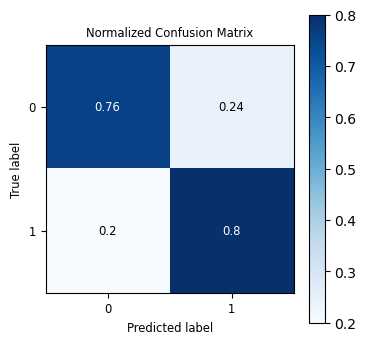

In [185]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

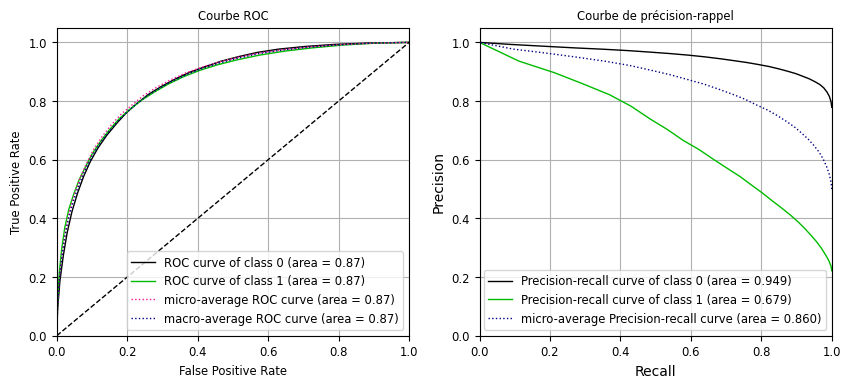

In [186]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

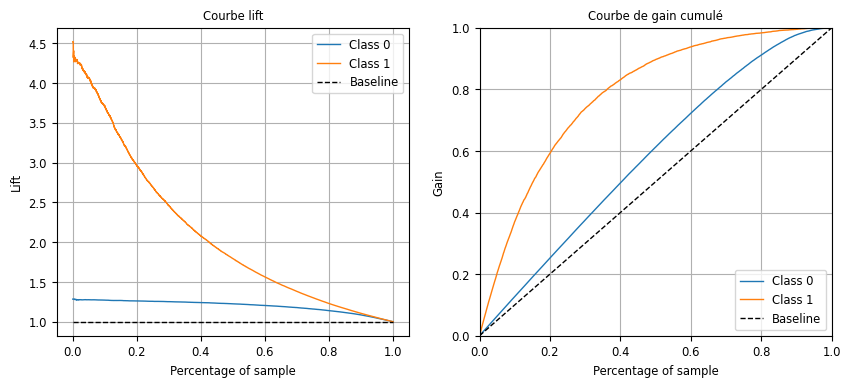

In [187]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [188]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_knn = pd.DataFrame(data=[cv_knn_train.values[0], cv_knn_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'], 
                     index=['knn : train', 'knn : test'])
cv_knn.index.name='Cross validation'
cv_knn.to_csv('../scores/cv_knn_'+param_ru+'.csv')
cv_knn

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
knn : train,0.780540,0.780567,0.780489,0.862762,0.054869,10.799405
knn : test,0.737564,0.707742,0.662852,0.855756,0.052967,9.579575


In [189]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_knn = {'knn' : df_metrics_probas_knn[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_knn]}

test_knn = pd.DataFrame(data=[data_knn['knn']], 
                        columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                        index=['knn'])
test_knn.index.name='Final Test'
test_knn.to_csv('../scores/test_knn_'+param_ru+'.csv')
test_knn

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
knn,0.605684,0.720882,0.781044,0.780715,0.781044


### Arbres de décision

#### class_weight = None

In [190]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight=None)

In [191]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['entropy','gini'], 'max_depth':np.arange(6,12,1)}

In [192]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt0 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt0.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [193]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt0.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'criterion': 'entropy', 'max_depth': 8}",0.762968,0.763179,0.762599,0.842124,0.149386,0.020998
2,"{'criterion': 'gini', 'max_depth': 7}",0.762700,0.762766,0.762581,0.842791,0.109510,0.020499
3,"{'criterion': 'entropy', 'max_depth': 9}",0.762657,0.762675,0.762626,0.836241,0.173037,0.021682


In [194]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt0.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt0.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt0.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 8} 

Train Data Score: 0.7820165317048586
Test Data Score: 0.7184077303695346


In [195]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_dt0_train = error_metrics(gcv_dt0.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_dt0_test = error_metrics(gcv_dt0.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_dt0_train)
display("TEST", cv_dt0_test)

'TRAIN'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.763105,0.763316,0.762737,0.842401,0.086303,0.012497


'TEST'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.731214,0.705649,0.663994,0.833261,0.084918,0.012544


In [196]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_dt0.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.286458,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.593137,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.501577,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.287511,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.436853,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [197]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_dt0 = compute_metrics_with_probas(df_probas_test, y_test)

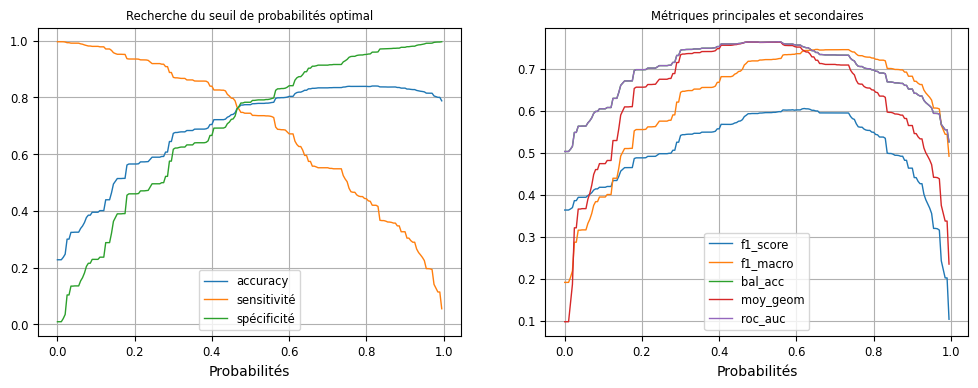

In [198]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_dt0)

In [199]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_dt0['Probabilités'].values
f = df_metrics_probas_dt0['sensitivité'].values
g = df_metrics_probas_dt0['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_dt0, y_prob_thres_dt0) = thres_info[0]

In [200]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_dt0.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_dt0).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_dt0)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.465

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24963  7927
1             2192  7155

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83     32890
           1       0.47      0.77      0.59      9347

    accuracy                           0.76     42237
   macro avg       0.70      0.76      0.71     42237
weighted avg       0.82      0.76      0.78     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.76      0.77      0.83      0.76      0.58     32890
          1       0.47      0.77      0.76      0.59      0.76      0.58      9347

avg / total       0.82      0.76      0.76      0.78      0.76      0.58     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.76-0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.59`

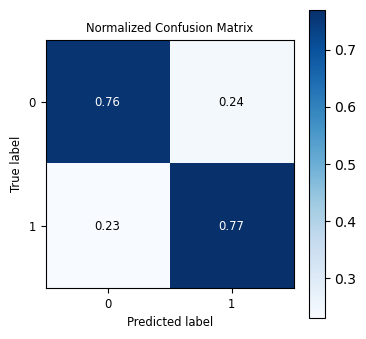

In [201]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

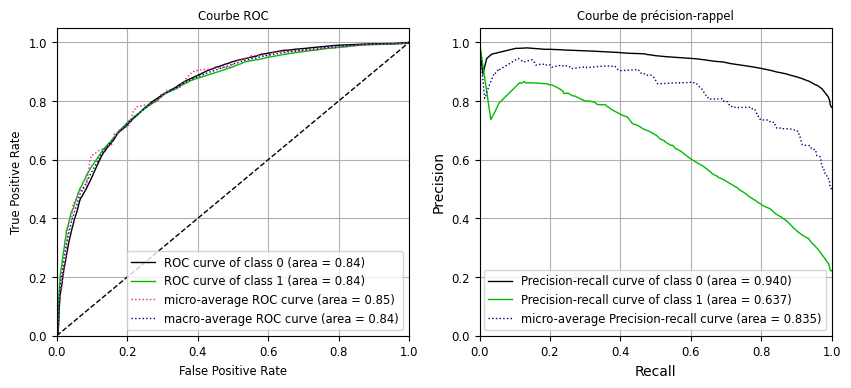

In [202]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

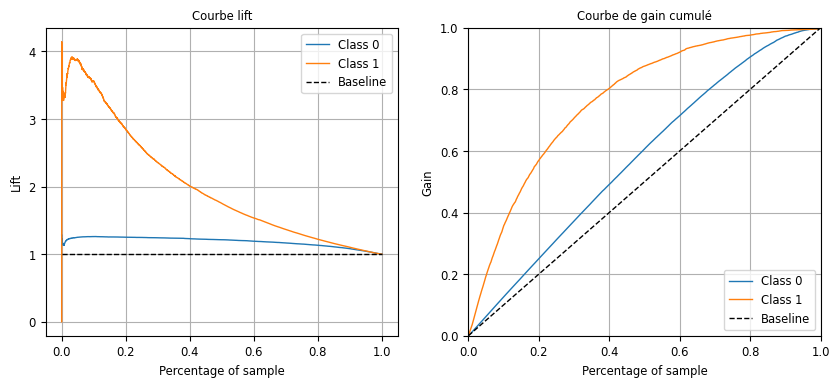

In [203]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weigth = 'balanced'

In [204]:
# définition du modèle
clf_dt = DecisionTreeClassifier(class_weight='balanced')

In [205]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['entropy','gini'], 'max_depth':np.arange(6,12,1)}

In [206]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt1 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': array([ 6,  7,  8,  9, 10, 11])},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [207]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt1.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'criterion': 'entropy', 'max_depth': 8}",0.763132,0.763339,0.762771,0.842336,0.160658,0.020044
2,"{'criterion': 'gini', 'max_depth': 7}",0.762860,0.762926,0.762740,0.842840,0.117290,0.020042
3,"{'criterion': 'entropy', 'max_depth': 7}",0.762556,0.762606,0.762467,0.843759,0.139264,0.016896


In [208]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt1.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'criterion': 'entropy', 'max_depth': 8} 

Train Data Score: 0.7820165317048586
Test Data Score: 0.718466764388325


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [209]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_dt1_train = error_metrics(gcv_dt1.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_dt1_test = error_metrics(gcv_dt1.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_dt1_train)
display("TEST", cv_dt1_test)

'TRAIN'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.763039,0.763247,0.762676,0.842285,0.090451,0.012058


'TEST'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.710826,0.755225,0.754819,0.827495,0.088865,0.011648


In [210]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_dt1.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.286458,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.593137,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.501577,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.287511,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.436853,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [211]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_dt1 = compute_metrics_with_probas(df_probas_test, y_test)

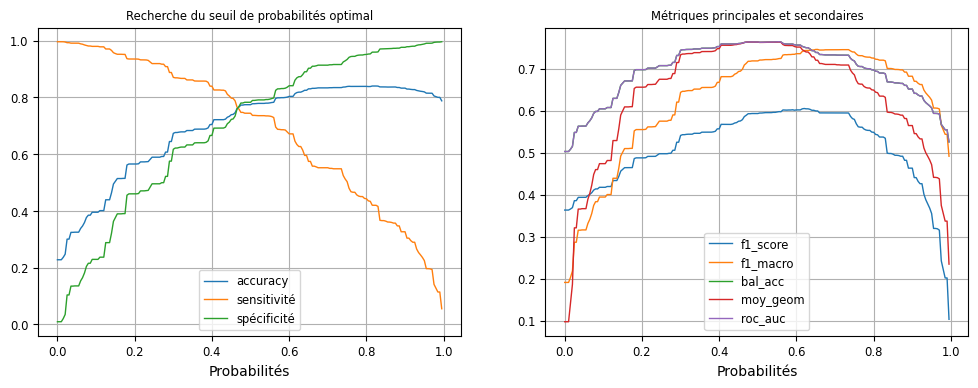

In [212]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_dt1)

In [213]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_dt1['Probabilités'].values
f = df_metrics_probas_dt1['sensitivité'].values
g = df_metrics_probas_dt1['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_dt1, y_prob_thres_dt1) = thres_info[0]

In [214]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_dt1.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_dt1).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_dt1)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.465

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24964  7926
1             2191  7156

 Classification_report:

               precision    recall  f1-score   support

           0       0.92      0.76      0.83     32890
           1       0.47      0.77      0.59      9347

    accuracy                           0.76     42237
   macro avg       0.70      0.76      0.71     42237
weighted avg       0.82      0.76      0.78     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.76      0.77      0.83      0.76      0.58     32890
          1       0.47      0.77      0.76      0.59      0.76      0.58      9347

avg / total       0.82      0.76      0.76      0.78      0.76      0.58     42237



- `0.75 < accuracy, sensibilité, spécificité, moyenne géométrique < 0.78`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.59`

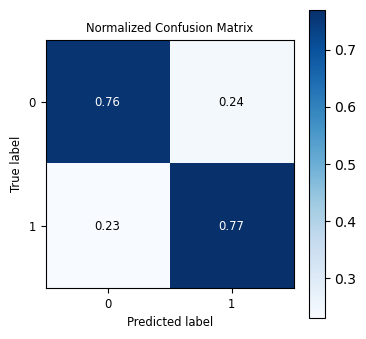

In [215]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

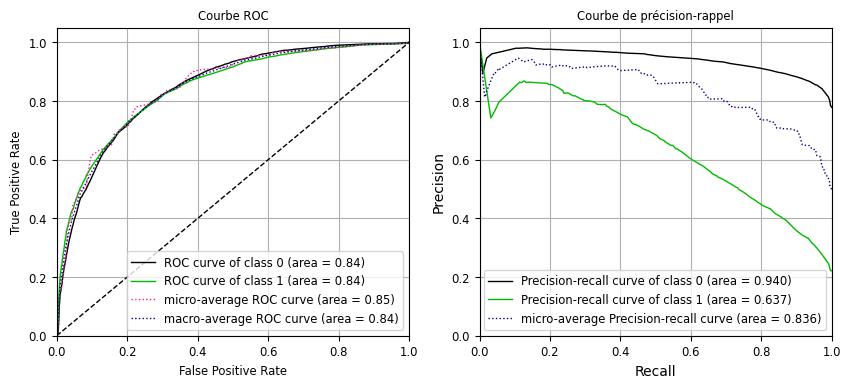

In [216]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

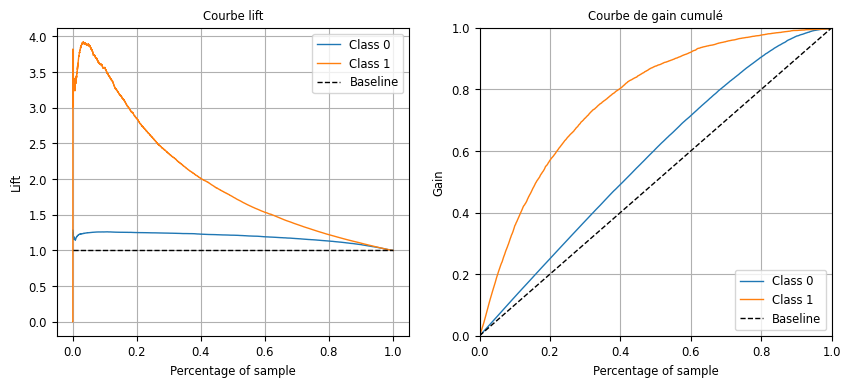

In [217]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### class_weight = {0:x, 1:1-x}

In [218]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

In [219]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.40,0.60,21)

In [220]:
# définition de la grille de paramètres pour GridSearchCV avec restriction des paramètres en fonction des résultats précédents
param_grid_dt = {'criterion':[gcv_dt0.best_params_['criterion']], 'max_depth':[gcv_dt0.best_params_['max_depth']], 
                 'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [221]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt2 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring=scoring, refit='f1', n_jobs=-1, cv=3, return_train_score=True)

# entraînement du modèle
gcv_dt2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.4, 1: 0.6},
                                          {0: 0.41000000000000003, 1: 0.59},
                                          {0: 0.42000000000000004, 1: 0.58},
                                          {0: 0.43, 1: 0.5700000000000001},
                                          {0: 0.44, 1: 0.56},
                                          {0: 0.45, 1: 0.55},
                                          {0: 0.46, 1: 0.54},
                                          {0: 0.47000000000000003, 1: 0.53},
                                          {0: 0.48, 1: 0.52},
                                          {0: 0.49, 1: 0.51}, {0: 0.5, 1: 0.5},
                                          {0: 0.51, 1: 0.49},
                                          {0: 0.52, 1: 0....
                                          {0: 0.55, 1: 0.44999999999999996},
                                          {0: 0.56, 1: 0.43999999999999995},
                                          {0: 0.5700000000000001,
                                           1: 0.42999999999999994},
                                          {0: 0.58, 1: 0.42000000000000004},
                                          {0: 0.59, 1: 0.41000000000000003},
                                          {0: 0.6, 1: 0.4}],
                         'criterion': ['entropy'], 'max_depth': [8]},
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'balanced_accuracy', 'auc': 'roc_auc',
                      'f1': 'f1_macro',
                      'geom_mean': make_scorer(geometric_mean_score)})

In [222]:
# affichage des meilleurs combinaisons possibles d'hyperparamètres et des performances moyennes du modèle associé
grid = pd.DataFrame.from_dict(gcv_dt2.cv_results_).loc[:,['params','rank_test_f1','mean_test_f1','mean_test_accuracy',
                                                          'mean_test_geom_mean','mean_test_auc','mean_fit_time','mean_score_time']]
grid.set_index('rank_test_f1').sort_values(by='rank_test_f1').head(3)

,params,mean_test_f1,mean_test_accuracy,mean_test_geom_mean,mean_test_auc,mean_fit_time,mean_score_time
rank_test_f1,,,,,,,
1,"{'class_weight': {0: 0.54, 1: 0.45999999999999996}, 'criterion': 'entropy', 'max_depth': 8}",0.763348,0.763979,0.762231,0.841755,0.154595,0.020257
2,"{'class_weight': {0: 0.51, 1: 0.49}, 'criterion': 'entropy', 'max_depth': 8}",0.763154,0.763361,0.762789,0.841856,0.150838,0.020291
3,"{'class_weight': {0: 0.49, 1: 0.51}, 'criterion': 'entropy', 'max_depth': 8}",0.763121,0.763316,0.762780,0.842448,0.161134,0.020049


In [223]:
# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt2.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt2.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt2.score(X_test_scaled, y_test)))

Meilleurs paramètres: {'class_weight': {0: 0.54, 1: 0.45999999999999996}, 'criterion': 'entropy', 'max_depth': 8} 

Train Data Score: 0.7816977150228888
Test Data Score: 0.722717130535365


- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

In [224]:
# validation croisée des scores obtenus par les métriques d'évaluation sur les ensembles d'entraînement et de test
cv_dt2_train = error_metrics(gcv_dt2.best_estimator_, X_train_scaled, y_train, kfold=3)
cv_dt2_test = error_metrics(gcv_dt2.best_estimator_, X_test_scaled, y_test, kfold=3)
display("TRAIN", cv_dt2_train)
display("TEST", cv_dt2_test)

'TRAIN'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.763343,0.763979,0.762216,0.84192,0.091891,0.012812


'TEST'

,f1,accuracy,geom_mean,auc,fit_time,score_time
cross-validation,0.721601,0.693762,0.644032,0.83361,0.088577,0.011709


In [225]:
# création d'un DataFrame réunissant les valeurs des prédictions de la classe positive en fonction du seuil de probabilités
y_probas_test = gcv_dt2.best_estimator_.predict_proba(X_test_scaled)
df_probas_test = create_probas_dataframe(X_test_scaled, y_probas_test, y_test)
df_probas_test.head()

,y_train_pred,y_test,Prévisions,0.0,0.005,0.01,0.015,0.02,0.025,0.03,...,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.985,0.99,0.995
86854,0.254835,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
66539,0.724331,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
45297,0.461568,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
99164,0.255813,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
62040,0.397885,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [226]:
# calcul de l'accuracy, de la sensibilité et de la précision de la classe positive en fonction du seuil de probabilités
df_metrics_probas_dt2 = compute_metrics_with_probas(df_probas_test, y_test)

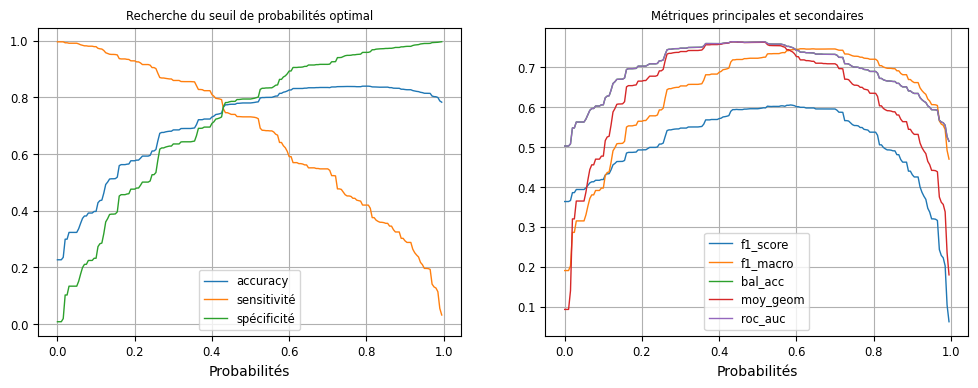

In [227]:
# affichage des courbes de métriques en fonction du seuil de probabilité
plot_metrics_with_probas(df_metrics_probas_dt2)

In [228]:
# recherche du point d'intersections des courbes pour obtenir le seuil de probabilités optimal 
x = df_metrics_probas_dt2['Probabilités'].values
f = df_metrics_probas_dt2['sensitivité'].values
g = df_metrics_probas_dt2['spécificité'].values

thres_info = [(i,x[i]) for i in range(len(f-g)-1) if (f-g)[i]*(f-g)[i+1] < 0.]
(ind_thres_dt2, y_prob_thres_dt2) = thres_info[0]

In [229]:
# prédictions du modèle à l'aide du seuil de probabilités optimal permettant de mieux distinguer les classes
y_probas_test = gcv_dt2.best_estimator_.predict_proba(X_test_scaled)
y_pred_test = (y_probas_test[:,1] >= y_prob_thres_dt2).astype(bool)
print("Seuil de probabilité optimal: ", y_prob_thres_dt2)

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred_test, rownames=['Réalités'], colnames=['Prédictions']))

# affichage du rapport de classification
print('\n Classification_report:')
print('\n', classification_report(y_test, y_pred_test))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n Classification_report_imbalanced:')
print('\n', classification_report_imbalanced(y_test, y_pred_test))

Seuil de probabilité optimal:  0.425

 Matrice de confusion:

 Prédictions  False  True
Réalités                
0            24052  8838
1             1941  7406

 Classification_report:

               precision    recall  f1-score   support

           0       0.93      0.73      0.82     32890
           1       0.46      0.79      0.58      9347

    accuracy                           0.74     42237
   macro avg       0.69      0.76      0.70     42237
weighted avg       0.82      0.74      0.76     42237


 Classification_report_imbalanced:

                    pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.73      0.79      0.82      0.76      0.58     32890
          1       0.46      0.79      0.73      0.58      0.76      0.58      9347

avg / total       0.82      0.74      0.78      0.76      0.76      0.58     42237



- `accuracy = sensibilité = spécificité = moyenne géométrique = 0.77`  

La classe positive est caractérisée par:
- une précision très faible, ce qui signifie que la classe n'est pas bien détectée
- un rappel élevé ce qui signifie que lorsque la classe est détectée, le modèle est fiable
- `F1-score = 0.6`

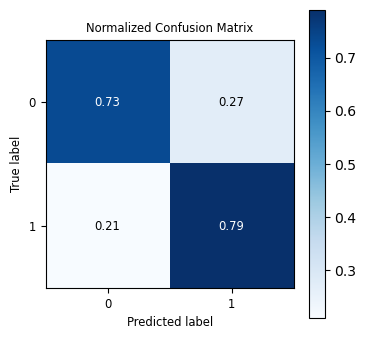

In [230]:
# affichage de la matrice de confusion normalisée
skplt.metrics.plot_confusion_matrix(y_test, y_pred_test, normalize=True, figsize=(4,4), title_fontsize='small', text_fontsize='small');

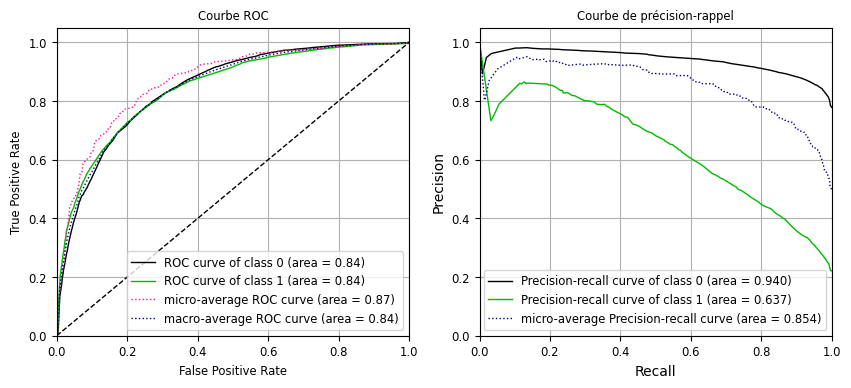

In [231]:
# affichage des courbes ROC et de précision-rappel
plot_roc_prec_rap(y_test, y_probas_test)

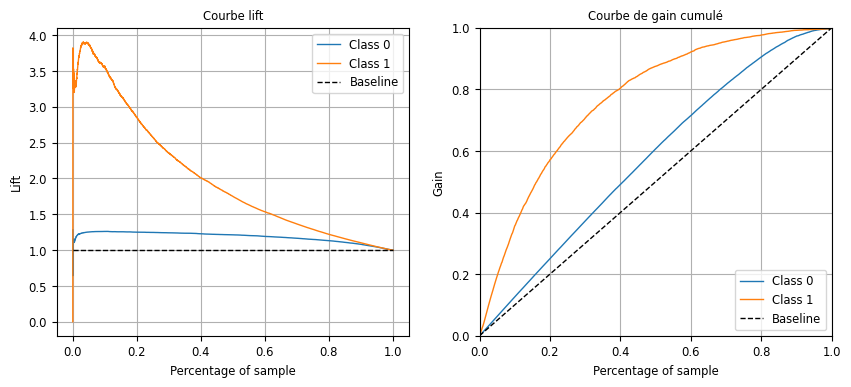

In [232]:
# affichage des courbes lift et de gain cumulé
plot_lift_gain(y_test, y_probas_test)

#### Sauvegarde des résultats

In [233]:
# sauvegarde des performances moyennes obtenues par cross-validation pour les différentes métriques d'évaluation 
cv_dt = pd.DataFrame(data=[cv_dt0_train.values[0], cv_dt0_test.values[0], cv_dt1_train.values[0], cv_dt1_test.values[0], 
                           cv_dt2_train.values[0], cv_dt2_test.values[0]], 
                     columns=['f1_macro','bal_acc','moy_geom','roc_auc','fit_time','score_time'],
                     index=['dt0 : train', 'dt0 : test', 'dt1 : train', 'dt1 : test', 'dt2 : train', 'dt2 : test'])
cv_dt.index.name='Cross validation'
cv_dt.to_csv('../scores/cv_dt_'+param_ru+'.csv')
cv_dt

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
dt0 : train,0.763105,0.763316,0.762737,0.842401,0.086303,0.012497
dt0 : test,0.731214,0.705649,0.663994,0.833261,0.084918,0.012544
dt1 : train,0.763039,0.763247,0.762676,0.842285,0.090451,0.012058
dt1 : test,0.710826,0.755225,0.754819,0.827495,0.088865,0.011648
dt2 : train,0.763343,0.763979,0.762216,0.841920,0.091891,0.012812
dt2 : test,0.721601,0.693762,0.644032,0.833610,0.088577,0.011709


In [234]:
# sauvegarde des métriques principales obtenues par le meilleur modèle sur le je de test 
data_dt = {'dt0' : df_metrics_probas_dt0[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_dt0],
           'dt1' : df_metrics_probas_dt1[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_dt1],
           'dt2' : df_metrics_probas_dt2[['f1_score','f1_macro','bal_acc','moy_geom','roc_auc']].values[ind_thres_dt2]}

test_dt = pd.DataFrame(data=[data_dt['dt0'], data_dt['dt1'], data_dt['dt2']], 
                       columns=['f1_score', 'f1_macro', 'bal_acc', 'moy_geom', 'roc_auc'], 
                       index=['dt0', 'dt1', 'dt2'])
test_dt.index.name='Final Test'
test_dt.to_csv('../scores/test_dt_'+param_ru+'.csv')
test_dt

,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
dt0,0.585779,0.708628,0.762235,0.762228,0.762235
dt1,0.585861,0.708685,0.762304,0.762297,0.762304
dt2,0.578797,0.697870,0.761813,0.761201,0.761813


## Résumé des performances

In [235]:
# concaténation des résultats de performance
if param_ru == 'rUs' or param_ru == 'cc':
    cv_lr_under_sample = pd.read_csv('../scores/cv_lr_'+param_ru+'.csv', index_col=0)
    cv_rf_under_sample = pd.read_csv('../scores/cv_rf_'+param_ru+'.csv', index_col=0)    
    cv_svm_under_sample = pd.read_csv('../scores/cv_svm_'+param_ru+'.csv', index_col=0)
    cv_knn_under_sample = pd.read_csv('../scores/cv_knn_'+param_ru+'.csv', index_col=0)
    cv_dt_under_sample = pd.read_csv('../scores/cv_dt_'+param_ru+'.csv', index_col=0)
    
    df_cv_under_sample = pd.concat([cv_lr_under_sample, cv_rf_under_sample, cv_svm_under_sample, 
                                    cv_knn_under_sample, cv_dt_under_sample], axis=0)
    
    test_lr_under_sample = pd.read_csv('../scores/test_lr_'+param_ru+'.csv', index_col=0)
    test_rf_under_sample = pd.read_csv('../scores/test_rf_'+param_ru+'.csv', index_col=0)    
    test_svm_under_sample = pd.read_csv('../scores/test_svm_'+param_ru+'.csv', index_col=0)
    test_knn_under_sample = pd.read_csv('../scores/test_knn_'+param_ru+'.csv', index_col=0)
    test_dt_under_sample = pd.read_csv('../scores/test_dt_'+param_ru+'.csv', index_col=0)
    
    df_test_under_sample = pd.concat([test_lr_under_sample, test_rf_under_sample, test_svm_under_sample, 
                                      test_knn_under_sample, test_dt_under_sample], axis=0)
elif param_ru == 'rOs' or param_ru == 'smo':
    cv_lr_over_sample = pd.read_csv('../scores/cv_lr_'+param_ru+'.csv', index_col=0)
    cv_rf_over_sample = pd.read_csv('../scores/cv_rf_'+param_ru+'.csv', index_col=0)    
    cv_svm_over_sample = pd.read_csv('../scores/cv_svm_'+param_ru+'.csv', index_col=0)
    cv_knn_over_sample = pd.read_csv('../scores/cv_knn_'+param_ru+'.csv', index_col=0)
    cv_dt_over_sample = pd.read_csv('../scores/cv_dt_'+param_ru+'.csv', index_col=0)
    
    df_cv_over_sample = pd.concat([cv_lr_over_sample, cv_rf_over_sample, cv_svm_over_sample, 
                                   cv_knn_over_sample, cv_dt_over_sample], axis=0)
    
    test_lr_over_sample = pd.read_csv('../scores/test_lr_'+param_ru+'.csv', index_col=0)
    test_rf_over_sample = pd.read_csv('../scores/test_rf_'+param_ru+'.csv', index_col=0)    
    test_svm_over_sample = pd.read_csv('../scores/test_svm_'+param_ru+'.csv', index_col=0)
    test_knn_over_sample = pd.read_csv('../scores/test_knn_'+param_ru+'.csv', index_col=0)
    test_dt_over_sample = pd.read_csv('../scores/test_dt_'+param_ru+'.csv', index_col=0)
    
    df_test_under_sample = pd.concat([test_lr_over_sample, test_rf_over_sample, test_svm_over_sample, 
                                      test_knn_over_sample, test_dt_over_sample], axis=0)

In [236]:
# affichage du résumé des performances
if param_ru == 'rUs' or param_ru == 'cc':
    display(df_cv_under_sample)
    display(df_test_under_sample)
elif param_ru == 'rOs' or param_ru == 'smo':
    display(df_cv_over_sample)
    display(df_test_over_sample)

,f1_macro,bal_acc,moy_geom,roc_auc,fit_time,score_time
Cross validation,,,,,,
lr0 : train,0.774572,0.774595,0.774529,0.856198,0.062813,0.011477
lr0 : test,0.738599,0.713352,0.675200,0.854338,0.081864,0.011420
lr1 : train,0.774549,0.774572,0.774506,0.856197,0.210129,0.010182
lr1 : test,0.724218,0.771663,0.771554,0.854631,0.188956,0.011145
lr2 : train,0.774549,0.774572,0.774506,0.856197,0.058230,0.011481
lr2 : test,0.738598,0.713375,0.675253,0.854337,0.070631,0.014553
rf0 : train,0.786413,0.786424,0.786391,0.871553,5.058741,0.852935
rf0 : test,0.748177,0.718118,0.677444,0.866210,4.955575,0.758133
rf1 : train,0.785947,0.785966,0.785910,0.870511,6.244574,0.998476


,f1_score,f1_macro,bal_acc,moy_geom,roc_auc
Final Test,,,,,
lr1,0.599413,0.719396,0.772318,0.772312,0.772318
lr2,0.599413,0.719396,0.772318,0.772312,0.772318
lr3,0.599388,0.719374,0.772302,0.772297,0.772302
rf0,0.621623,0.736925,0.787982,0.787981,0.787982
rf1,0.622077,0.736842,0.788919,0.788911,0.788919
rf2,0.621099,0.736475,0.787678,0.787677,0.787678
svm0,0.612058,0.729644,0.781015,0.781014,0.781015
svm1,0.611697,0.729226,0.780933,0.780932,0.780933
svm2,0.616739,0.732989,0.784738,0.784736,0.784738
